In [1]:
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.cm as cm
from scipy.optimize import curve_fit
import matplotlib as mpl
import struct
import glob
import os 
import struct
from sklearn import linear_model
import scipy.linalg
from scipy import stats
from scipy import integrate
from scipy.stats import powerlaw
hubble = 0.73
vmax_MW = 220.0
vmax_M31 = 270.0
m_star_M31 = 10.3
m_star_MW = 6.08

%matplotlib inline

In [2]:
def load_summary(filename):
    dtype=[('minr', 'f8'),
           ('maxr', 'f8'), 
           ('ca_ratio', 'f8'),
           ('ba_ratio', 'f8'),
           ('a', 'f8'),
           ('center', 'f8'),
           ('width', 'f8'),
           ('mu', 'f8')]
    summary = np.loadtxt(filename, dtype=dtype)    
    return summary

In [3]:
def load_snapshot(snap_name, boxsize=75000.0, elvis=False):
    if elvis:
        dtype=[('haloid','i8'),
            ('x', 'f8'),('y', 'f8'), ('z', 'f8'),
            ('vx', 'f8'),('vy', 'f8'),('vz', 'f8'),
            ('vmax', 'f8'),('vmaxpeak', 'f8'),
            ('virmass', 'f8'),('virmasspeak', 'f8'),  
            ('virradius', 'f8'),('peakradius', 'f8'),
            ('aexppeak', 'f8'),
            ('mstar', 'f8'),('mstarbehrooze', 'f8'),
            ('npart', 'i8'),
           ('parentid','i8'),('upid', 'i8')]
    else:
        dtype=[('subid','i8'),
           ('parentid','i8'),
           ('x', 'f8'),
           ('y', 'f8'), 
           ('z', 'f8'),
           ('vx', 'f8'),
           ('vy', 'f8'),
           ('vz', 'f8'),
           ('vmax', 'f8'),
           ('bmag', 'f8'),
           ('vmag', 'f8'),
           ('mstar', 'f8')]
    snap_data = np.loadtxt(snap_name, dtype=dtype) 
    print('reading {}'.format(snap_name))
    if not elvis:
        # this takes into account periodic boudary conditions from Illustris
        for col in list(['x','y','z']):
            if((snap_data[col].max() - snap_data[col].min()) > 0.5 * boxsize):
                snap_data[col] = (snap_data[col] - 0.5 * boxsize) % boxsize
    if elvis: #change units
        for col in list(['x','y','z']):
            snap_data[col] = snap_data[col] * 1000/hubble
    return snap_data

In [4]:
def load_obs(obs_name):
    dtype=[('name','|S20'),
           ('x', 'f8'),
           ('y', 'f8'), 
           ('z', 'f8'),
           ('delta_plus', 'f8'),
           ('delta_minus', 'f8'),
           ('vmag', 'f8'),
           ('delta_vmag', 'f8')]
    obs_data = np.loadtxt(obs_name, dtype=dtype)    
    return obs_data

In [5]:
def main_halos(snap_data, sort_column='mstar', single_reverse=False):
    id_sorted = np.argsort(snap_data[sort_column])
    if single_reverse:
        id_halo_A = id_sorted[0]
        main_halos_data = snap_data[id_halo_A]
    else:
        id_halo_A = id_sorted[-1]
        id_halo_B = id_sorted[-2]
        main_halos_data = snap_data[[id_halo_A, id_halo_B]]
    return main_halos_data

In [6]:
def satellite_halos(halo_data, halo_center, radius=300, 
                    max_points=-1, max_initial_points=-1,sort_column='vmag', reverse=False, randomize=False):
        
    jj = np.argsort(halo_data[sort_column])
    if reverse:
        jj = jj[::-1]
        
    tmp_halo = halo_data[jj]
    #if vmax is None:
    #    radius = halo_center['vmax']/(10.0 * 100 * hubble) * 1000 # in kpc
    #else:
    #    radius = vmax/(10.0 * 100 * hubble) * 1000  # in kpc
    
    for col in list(['x','y','z']):
        tmp_halo[col] = tmp_halo[col] - halo_center[col]
    
    r = np.sqrt(tmp_halo['x']**2 + tmp_halo['y']**2 + tmp_halo['z']**2)
    ii = (r < radius) & (r>1E-6)
    
    tmp_halo = tmp_halo[ii]
    r = np.sqrt(tmp_halo['x']**2 + tmp_halo['y']**2 + tmp_halo['z']**2)
    
    if max_initial_points>0 :
        tmp_halo = tmp_halo[:max_initial_points]
        r = np.sqrt(tmp_halo['x']**2 + tmp_halo['y']**2 + tmp_halo['z']**2)

    if max_points > 0:
        if randomize:
            jj = np.argsort(np.random.random(len(tmp_halo)))
            return tmp_halo[jj[:max_points]], np.min(r[jj[:max_points]]), np.max(r[jj[:max_points]])
        else:
            return tmp_halo[:max_points], np.min(r[:max_points]), np.max(r[:max_points])
    else:
        return tmp_halo, np.min(r), np.max(r)

In [7]:
def spherical_randomize(x_in, y_in, z_in):
    """
    Randomizes a set of points around the coordinates origin.
    """
    n_points = len(x_in)
    r = np.sqrt(x_in**2 + y_in**2 + z_in**2)
    phi = np.random.random(n_points) * 2.0 * np.pi
    costheta = 2.0*(np.random.random(n_points) -0.5)
    theta = np.arccos(costheta)
    x = r * np.sin(theta) * np.cos(phi)
    y = r * np.sin(theta) * np.sin(phi)
    z = r * np.cos(theta)
    return x, y, z

In [8]:
def inertiaTensor(x_in,y_in,z_in, randomize=False):
    # first recenter the data
    x = x_in - np.mean(x_in)
    y = y_in - np.mean(y_in)
    z = z_in - np.mean(z_in)
    if randomize:
        x, y, z = spherical_randomize(x_in - np.mean(x_in), 
                                      y_in - np.mean(y_in), 
                                      z_in - np.mean(z_in))
    
    I=[]
    for index in range(9):
        I.append(0)
   
    I[0] = np.sum(y*y+z*z) 
    I[1] = np.sum(-y*x)    
    I[2] = np.sum(-x*z)    
    I[3] = np.sum(-y*x)    
    I[4] = np.sum(x*x+z*z) 
    I[5] = np.sum(-y*z)    
    I[6] = np.sum(-z*x)    
    I[7] = np.sum(-z*y)    
    I[8] = np.sum(x*x+y*y) 
    tensor = np.array([(I[0:3]), (I[3:6]), (I[6:9])])
    vals, vects = np.linalg.eig(tensor)  # they come out unsorted, so the command below is needed
    eig_ord = np.argsort(vals)  # a thing to note is that here COLUMN i corrensponds to eigenvalue i.
    ord_vals = vals[eig_ord]
    ord_vects = vects[:, eig_ord].T
    
    plane_vector = ord_vects[2]
    distance_to_plane = x * plane_vector[0]
    distance_to_plane += y * plane_vector[1]
    distance_to_plane += z * plane_vector[2]

    #use ord_vects[2] to define the plane width
    return ord_vals, plane_vector, distance_to_plane.mean(), distance_to_plane.std()

In [9]:
def gen_random_sphere(n_points):
    """
    Sets of points in the 3D sphere
    """
    r = np.random.random(n_points)**(1.0/3.0)
    phi = np.random.random(n_points) * 2.0 * np.pi
    costheta = 2.0*(np.random.random(n_points) -0.5)
    theta = np.arccos(costheta)
    x = r * np.sin(theta) * np.cos(phi)
    y = r * np.sin(theta) * np.sin(phi)
    z = r * np.cos(theta)
    return x, y, z

In [10]:
def write_inertia_plane(output_stream, satellite_data, center_data, unit_vector=[0,0,1], randomize=False):
    # inertia tensor
    x_pos = satellite_data['x'] 
    y_pos = satellite_data['y'] 
    z_pos = satellite_data['z'] 

    values, vec_a, center, width = inertiaTensor(x_pos, y_pos, z_pos, randomize=randomize)
    
    output_stream.write("{:.2e}  {:.2e}  {:.2e}\t".format(values[0]/values[2], 
                                                          values[1]/values[2], 
                                                          values[2]))
    mu_I = 0
    for i in range(3):
        mu_I += vec_a[i]* unit_vector[i]
        
    output_stream.write("{:.4f} {:.4f} {:.4f}\t".format(center, width, np.abs(mu_I)))
    return
    

def write_center_info(output_stream, center_A, center_B):
    #distance between halos in kpc/h and vector connecting the two halos
    r_AB = np.ones(3)
    r_AB[0] = center_A['x'] - center_B['x']
    r_AB[1] = center_A['y'] - center_B['y']
    r_AB[2] = center_A['z'] - center_B['z']
    d_AB =  np.sqrt(np.sum(r_AB**2))
    r_AB = r_AB/d_AB
    return r_AB

In [14]:
def make_stats(group_id=0, iter_id=0, n_sat_max=3, n_sat_min=11, n_random=1000, 
                         elvis = False,
                         obs_data=False,
                         reverse=False,
                         sort_column='vmax',
                         randomize=False,
                         data_path = "../data/mstar_selected/", 
                         obs_data_path = "../data/obs/"):    
    if obs_data:
        MW_data = load_obs(os.path.join(obs_data_path, "MW_satellites.txt"))
        M31_data = load_obs(os.path.join(obs_data_path, "M31_satellites.txt"))
    
        M31 = main_halos(M31_data, sort_column='vmag', single_reverse=True)
        MW = main_halos(MW_data, sort_column='vmag', single_reverse=True)
    else:
        if elvis:
            base_name = 'elvis'
        else:
            base_name = 'Illustris_group'
        M31_data = load_snapshot(os.path.join(data_path, "{}_{}.dat".format(base_name, group_id)), elvis=elvis)
        MW_data = load_snapshot(os.path.join(data_path, "{}_{}.dat".format(base_name, group_id)), elvis=elvis)
        LG_data = load_snapshot(os.path.join(data_path, "{}_{}.dat".format(base_name, group_id)), elvis=elvis)
        M31, MW = main_halos(LG_data, sort_column=sort_column, single_reverse=False)
   
    
    satellite_data_A, min_r_M31, max_r_M31 = satellite_halos(M31_data, M31,sort_column=sort_column)
    satellite_data_B, min_r_MW, max_r_MW = satellite_halos(MW_data, MW, sort_column=sort_column)
    N_A = len(satellite_data_A)
    N_B = len(satellite_data_B)
    
    r = np.ones(3)
    r[0] = MW['x'] - M31['x']
    r[1] = MW['y'] - M31['y']
    r[2] = MW['z'] - M31['z']
    norm_r = np.sqrt(np.sum(r**2))
    v = np.ones(3)
    v[0] = MW['vx'] - M31['vx']
    v[1] = MW['vy'] - M31['vy']
    v[2] = MW['vz'] - M31['vz']
    norm_v = np.sqrt(np.sum(v**2))
    v_rad = (v[0]*r[0] + v[1]*r[1] + v[2]*r[2])/norm_r
    
    if((N_A < n_sat_min) | (N_B <n_sat_min)):
        print('Failed Check Groupid, N bright:!', group_id, N_A, N_B)
        return {}
    else:
        return {'M31':{'vmax':M31['vmax']}, 'MW':{'vmax':MW['vmax']}, 'LG':{'d':norm_r, 'v':norm_v, 'v_rad':v_rad}}

In [33]:
input_path = "../data/illustris1_mstar_selected/"
illu = dict()
for i in range(27):
    A = make_stats(group_id=i, n_sat_max=11, n_sat_min=15, iter_id=0, n_random=1000, 
                   data_path=input_path, sort_column='vmax', 
                   reverse=True, randomize=False)
    if len(A):
        illu[i] = A
        #print(A)
        
input_path = "../data/illustris1dark_mstar_selected/"
illudm = dict()
for i in range(27):
    A = make_stats(group_id=i, n_sat_max=11, n_sat_min=15, iter_id=0, n_random=1000, 
                   data_path=input_path, sort_column='vmax', 
                   reverse=True, randomize=False)
    if len(A):
        illudm[i] = A
        #print(A)
        
input_path = "../data/elvis_mstar_selected/"
elvis = dict()
for i in range(12):
    A = make_stats(group_id=i, n_sat_max=11, n_sat_min=15, iter_id=0, n_random=1000, 
                   data_path=input_path, sort_column='vmax', 
                   reverse=True, randomize=False, elvis=True)
    if len(A):
        elvis[i] = A
        print(A)

reading ../data/illustris1_mstar_selected/Illustris_group_0.dat
reading ../data/illustris1_mstar_selected/Illustris_group_0.dat
reading ../data/illustris1_mstar_selected/Illustris_group_0.dat
reading ../data/illustris1_mstar_selected/Illustris_group_1.dat
reading ../data/illustris1_mstar_selected/Illustris_group_1.dat
reading ../data/illustris1_mstar_selected/Illustris_group_1.dat
reading ../data/illustris1_mstar_selected/Illustris_group_2.dat
reading ../data/illustris1_mstar_selected/Illustris_group_2.dat
reading ../data/illustris1_mstar_selected/Illustris_group_2.dat
reading ../data/illustris1_mstar_selected/Illustris_group_3.dat
reading ../data/illustris1_mstar_selected/Illustris_group_3.dat
reading ../data/illustris1_mstar_selected/Illustris_group_3.dat
reading ../data/illustris1_mstar_selected/Illustris_group_4.dat
reading ../data/illustris1_mstar_selected/Illustris_group_4.dat
reading ../data/illustris1_mstar_selected/Illustris_group_4.dat
reading ../data/illustris1_mstar_selecte

20 24 12



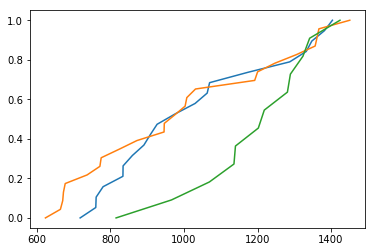

In [59]:
n_illu = len(illu)
n_illudm = len(illudm)
n_elvis = len(elvis)
print(n_illu, n_illudm, n_elvis)
obj = 'LG'
field = 'd'

field_illu = np.ones(n_illu)
i = 0
for k in illu.keys():
    field_illu[i] = illu[k][obj][field]
    i = i+1
    
field_illudm = np.ones(n_illudm)
i = 0
for k in illudm.keys():
    field_illudm[i] = illudm[k][obj][field]
    i = i+1
    
field_elvis = np.ones(n_elvis)
i = 0
for k in elvis.keys():
    field_elvis[i] = elvis[k][obj][field]
    i = i+1
    
field_illu.sort()
field_illudm.sort()
field_elvis.sort()
print()
plt.plot(field_illu, np.linspace(0,1,n_illu))
plt.plot(field_illudm, np.linspace(0,1,n_illudm))
plt.plot(field_elvis, np.linspace(0,1,n_elvis))